In [7]:
import mne
import os
import sys
import pytz
import datetime
import numpy as np
import pandas as pd


In [8]:
# Add the src directory to the path
sys.path.insert(0, '..')
from src.features.feature_generation_utils import *
from src.features.feature_generation import *

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents
## [Load Data](#load_data)
- ### [Load Labels](#load_labels)
- ### [Generate Features](#generate_features_v2)
## [Machine Learning](#machine_learning_v2_features)
- ### [Random Forest Classifier](#random_forest_classifier)
- ### [KNN Classifier](#knn_classifier)
- ### [Nap Plotting](#nap_plotting)

<a id='load_data'></a>
# Load data

In [10]:
path_to_edf = '../data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf'
raw = mne.io.read_raw_edf(path_to_edf, include=['ECG_Raw_Ch1', 'EEG_ICA5', 'Pressure', 'ODBA', 'GyrZ'], preload=True)
info = raw.info

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158957499  =      0.000 ... 317914.998 secs...


<a id='load_labels'></a>
## Load labels

In [11]:
# Load labeled data
# Path to CSV with scored data
file_path = '../data/raw/02_hypnogram_data/test12_Wednesday_06_Hypnogram_JKB_1Hz.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['R.Time'] = pd.to_datetime(df['R.Time']).dt.tz_localize('America/Los_Angeles')
df['Sleep.Code'].value_counts(normalize=True)

Sleep.Code
Active Waking         0.456175
Quiet Waking          0.143221
HV Slow Wave Sleep    0.124564
Drowsiness            0.075781
Certain REM Sleep     0.072228
LV Slow Wave Sleep    0.071997
Putative REM Sleep    0.034134
Unscorable            0.021901
Name: proportion, dtype: float64

In [12]:
sfreq = info['sfreq']
edf_start_time = info['meas_date']
# Define the PST timezone
pst_timezone = pytz.timezone('America/Los_Angeles')
# Convert to datetime object in PST
if isinstance(edf_start_time, datetime.datetime):
    # If it's already a datetime object, just replace the timezone
    recording_start_datetime = edf_start_time.replace(tzinfo=None).astimezone(pst_timezone)
    # for some reason using .replace(tzinfo=...) does weird shit - offsets based of LMT instead of UTC and gets confusing
    # recording_start_datetime = edf_start_time.replace(tzinfo=pst_timezone)
elif isinstance(edf_start_time, (int, float)):
    # Convert timestamp to datetime in PST
    recording_start_datetime = pst_timezone.localize(datetime.datetime.fromtimestamp(edf_start_time))

<a id='generate_features_v2'></a>
# Generate (or load) features v2

In [13]:
print(recording_start_datetime)
print(recording_start_datetime.tzinfo)
print(recording_start_datetime.astimezone())

2019-10-25 08:21:02-07:00
America/Los_Angeles
2019-10-25 08:21:02-07:00


In [14]:
eeg_data = mne.io.read_raw_edf(path_to_edf, include=['EEG_ICA5'], preload=True).get_data('EEG_ICA5')[0]

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 158957499  =      0.000 ... 317914.998 secs...


### Skip ahead if you've already generated the v2 features
#### Skip ahead to: [Load v2 features](#load_v2_features)

In [45]:
features_all = generate_features(path_to_edf)

Extracting EDF parameters from /Users/michael/Desktop/capstone-seal-sleep/jessie-workshop/ecophys-ecoviz/data/raw/01_edf_data/test12_Wednesday_05_ALL_PROCESSED.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

--------------------------------------------------
starting heart rate
Filled: 0
done

--------------------------------------------------
Starting Features (and lengths of feature vectors):
Time 317915
Heart Rate 317915
Pressure Mean 317915
Pressure Std.Dev 317915
ODBA Mean 317915
ODBA Std.Dev 317915
GyrZ Mean 317915
GyrZ Std.Dev 317915
--------------------------------------------------
starting yasa EEG features
100.00% complete!

done

--------------------------------------------------
starting yasa heart rate features
100.00% complete!

done

--------------------------------------------------
NA Values:
 Heart Rate                    0
Pressure Mean                29
Pressure Std.Dev             29
ODBA Mean                    29
ODBA S

In [46]:
# Data with target, drop start and end sections that aren't scored because sensors not set up yet or taking off
features_labeled = features_all[(features_all.index >= df['R.Time'].min()) &
                               (features_all.index <= df['R.Time'].max())]
features_labeled[['Sleep.Code', 'Simple.Sleep.Code']] = df.set_index('R.Time', drop=True)[['Sleep.Code', 'Simple.Sleep.Code']]

features_labeled.to_csv('../data/processed/v2_features/Wednesday_features_v2_with_labels.csv')

<a id='load_v2_features'></a>
#### Load v2 features

In [47]:
features_labeled = pd.read_csv('../data/processed/v2_features/Wednesday_features_v2_with_labels.csv',
                               index_col=0)

In [48]:
features_labeled.index = pd.DatetimeIndex(features_labeled.index, tz=pst_timezone)

In [49]:
features_labeled.isna().sum()

Heart Rate                  0
Pressure Mean               0
Pressure Std.Dev            0
ODBA Mean                   0
ODBA Std.Dev                0
GyrZ Mean                   0
GyrZ Std.Dev                0
yasa_eeg_std                0
yasa_eeg_iqr                0
yasa_eeg_skew               0
yasa_eeg_kurt               0
yasa_eeg_nzc                0
yasa_eeg_hmob               0
yasa_eeg_hcomp              0
yasa_eeg_sdelta             0
yasa_eeg_fdelta             0
yasa_eeg_theta              0
yasa_eeg_alpha              0
yasa_eeg_sigma              0
yasa_eeg_beta               0
yasa_eeg_dt                 0
yasa_eeg_ds                 0
yasa_eeg_db                 0
yasa_eeg_at                 0
yasa_eeg_abspow             0
yasa_eeg_sdelta_relative    0
yasa_eeg_fdelta_relative    0
yasa_eeg_theta_relative     0
yasa_eeg_alpha_relative     0
yasa_eeg_sigma_relative     0
yasa_eeg_beta_relative      0
yasa_eeg_perm               0
yasa_eeg_higuchi            0
yasa_eeg_p

<a id='machine_learning_v2_features'></a>
# ML with yasa features, pressure, ODBA, GyrZ


<a id='random_forest_classifier'></a>
## Random Forest Classifier
(using grid-searched parameters from part 02_initial_models_features_v1.ipynb)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [51]:
model_rf = RandomForestClassifier(**{'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2',
                                     'n_estimators': 50}, n_jobs=8)
model_data = features_labeled.drop(['Sleep.Code'], axis=1).dropna() #too many nas figure out later
X_test, X_train, y_test, y_train = train_test_split(model_data.drop('Simple.Sleep.Code', axis=1),
                                                    model_data['Simple.Sleep.Code'], test_size=0.5, shuffle=False)

In [52]:
y_test.value_counts()

Simple.Sleep.Code
Active Waking    46305
SWS              34305
Quiet Waking     24055
REM              23703
Drowsiness       17317
Unscorable        1661
Name: count, dtype: int64

In [53]:
model_data.columns

Index(['Heart Rate', 'Pressure Mean', 'Pressure Std.Dev', 'ODBA Mean',
       'ODBA Std.Dev', 'GyrZ Mean', 'GyrZ Std.Dev', 'yasa_eeg_std',
       'yasa_eeg_iqr', 'yasa_eeg_skew', 'yasa_eeg_kurt', 'yasa_eeg_nzc',
       'yasa_eeg_hmob', 'yasa_eeg_hcomp', 'yasa_eeg_sdelta', 'yasa_eeg_fdelta',
       'yasa_eeg_theta', 'yasa_eeg_alpha', 'yasa_eeg_sigma', 'yasa_eeg_beta',
       'yasa_eeg_dt', 'yasa_eeg_ds', 'yasa_eeg_db', 'yasa_eeg_at',
       'yasa_eeg_abspow', 'yasa_eeg_sdelta_relative',
       'yasa_eeg_fdelta_relative', 'yasa_eeg_theta_relative',
       'yasa_eeg_alpha_relative', 'yasa_eeg_sigma_relative',
       'yasa_eeg_beta_relative', 'yasa_eeg_perm', 'yasa_eeg_higuchi',
       'yasa_eeg_petrosian', 'yasa_heartrate_mean', 'yasa_heartrate_std',
       'yasa_heartrate_iqr', 'yasa_heartrate_skew', 'yasa_heartrate_kurt',
       'yasa_heartrate_hmob', 'yasa_heartrate_hcomp', 'yasa_heartrate_vlf',
       'yasa_heartrate_lf', 'yasa_heartrate_hf', 'yasa_heartrate_lf/hf',
       'yasa_heart

In [54]:
model_rf.fit(X_train, y_train)
preds = model_rf.predict(X_test)
preds = pd.Series(preds, index=y_test.index)

In [55]:
preds.value_counts()

Active Waking    67225
Quiet Waking     37841
SWS              22948
REM              12219
Drowsiness        6931
Unscorable         182
Name: count, dtype: int64

In [56]:
y_test.value_counts()

Simple.Sleep.Code
Active Waking    46305
SWS              34305
Quiet Waking     24055
REM              23703
Drowsiness       17317
Unscorable        1661
Name: count, dtype: int64

In [57]:
from sklearn.metrics import confusion_matrix
def display_conf_matr_and_class_acc(y_true, y_predicted):
    # Overall accuracy
    print('-'*110 + '\nOverall accuracy:', '{0:.3f}'.format(np.mean(y_true == y_predicted)), sep='\t')
    # Confusion matrix
    print('-'*110 + '\nConfusion matrix')
    labels = np.unique(y_true)
    conf_matr = confusion_matrix(y_test, y_predicted, labels=labels)
    conf_matr = pd.DataFrame(conf_matr, columns='Predicted ' + labels, index='True ' + labels)
    display(conf_matr)
    
    # Class accuracies
    print('-'*110 + '\nClass Accuracies')
    class_accuracies = conf_matr.to_numpy().diagonal() / np.sum(conf_matr, axis=1)
    class_accuracies = pd.DataFrame(class_accuracies, columns=['Accuracy']).T[
        ['True Active Waking', 'True Quiet Waking', 'True Drowsiness', 'True SWS', 'True REM', 'True Unscorable']
    ]
    # get rid of the "True " prefix
    class_accuracies.columns = pd.Series(class_accuracies.columns).apply(lambda x: x[5:]).values 
    display(class_accuracies.round(3))
    print('-'*110)

In [58]:
display_conf_matr_and_class_acc(y_test.values, preds.values)

--------------------------------------------------------------------------------------------------------------
Overall accuracy:	0.629
--------------------------------------------------------------------------------------------------------------
Confusion matrix


,Predicted Active Waking,Predicted Drowsiness,Predicted Quiet Waking,Predicted REM,Predicted SWS,Predicted Unscorable
True Active Waking,43267,158,2708,70,16,86
True Drowsiness,4563,5023,6901,96,734,0
True Quiet Waking,11022,715,11424,877,17,0
True REM,383,277,11991,10897,155,0
True SWS,6552,705,4743,279,22026,0
True Unscorable,1438,53,74,0,0,96


--------------------------------------------------------------------------------------------------------------
Class Accuracies


,Active Waking,Quiet Waking,Drowsiness,SWS,REM,Unscorable
Accuracy,0.934,0.475,0.29,0.642,0.46,0.058


--------------------------------------------------------------------------------------------------------------


<a id='knn_classifier'></a>
## KNN

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
model_knn = KNeighborsClassifier(**{'metric': 'minkowski', 'n_neighbors': 100, 'p': 1, 'weights': 'distance'},
                                 n_jobs=8)

In [61]:
model_knn.fit(X_train, y_train)
preds_knn = model_knn.predict(X_test)
preds_knn = pd.Series(preds_knn, index=y_test.index)

In [62]:
display_conf_matr_and_class_acc(y_test.values, preds_knn.values)

--------------------------------------------------------------------------------------------------------------
Overall accuracy:	0.631
--------------------------------------------------------------------------------------------------------------
Confusion matrix


,Predicted Active Waking,Predicted Drowsiness,Predicted Quiet Waking,Predicted REM,Predicted SWS,Predicted Unscorable
True Active Waking,41976,1213,1699,146,796,475
True Drowsiness,4392,8862,3078,247,738,0
True Quiet Waking,11738,4583,5897,744,1093,0
True REM,2149,2080,7393,11939,142,0
True SWS,6506,1769,1207,600,24215,8
True Unscorable,1505,21,58,20,28,29


--------------------------------------------------------------------------------------------------------------
Class Accuracies


,Active Waking,Quiet Waking,Drowsiness,SWS,REM,Unscorable
Accuracy,0.907,0.245,0.512,0.706,0.504,0.017


--------------------------------------------------------------------------------------------------------------


<a id='lightgbm'></a>
## LightGBM

In [63]:
from lightgbm import LGBMClassifier

In [64]:
lgbm_clf = LGBMClassifier(**{'learning_rate': 0.005, 'n_estimators': 400, 'num_leaves': 10})
lgbm_clf.fit(X_train, y_train)
lbgm_preds = pd.Series(lgbm_clf.predict(X_test), index=y_test.index)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 147346, number of used features: 51
[LightGBM] [Info] Start training from score -0.514016
[LightGBM] [Info] Start training from score -3.380350
[LightGBM] [Info] Start training from score -2.094058
[LightGBM] [Info] Start training from score -2.959255
[LightGBM] [Info] Start training from score -1.830690
[LightGBM] [Info] Start training from score -3.425627


In [65]:
display_conf_matr_and_class_acc(y_test.values, lbgm_preds.values)

--------------------------------------------------------------------------------------------------------------
Overall accuracy:	0.625
--------------------------------------------------------------------------------------------------------------
Confusion matrix


,Predicted Active Waking,Predicted Drowsiness,Predicted Quiet Waking,Predicted REM,Predicted SWS,Predicted Unscorable
True Active Waking,43916,205,2033,47,16,88
True Drowsiness,4643,4449,7385,181,659,0
True Quiet Waking,13510,906,8559,1049,31,0
True REM,843,1044,9100,12573,143,0
True SWS,7796,700,2480,755,22574,0
True Unscorable,1576,41,25,0,3,16


--------------------------------------------------------------------------------------------------------------
Class Accuracies


,Active Waking,Quiet Waking,Drowsiness,SWS,REM,Unscorable
Accuracy,0.948,0.356,0.257,0.658,0.53,0.01


--------------------------------------------------------------------------------------------------------------


Text(0.5, 1.0, 'Feature Importance for LightGBM with v2 features')

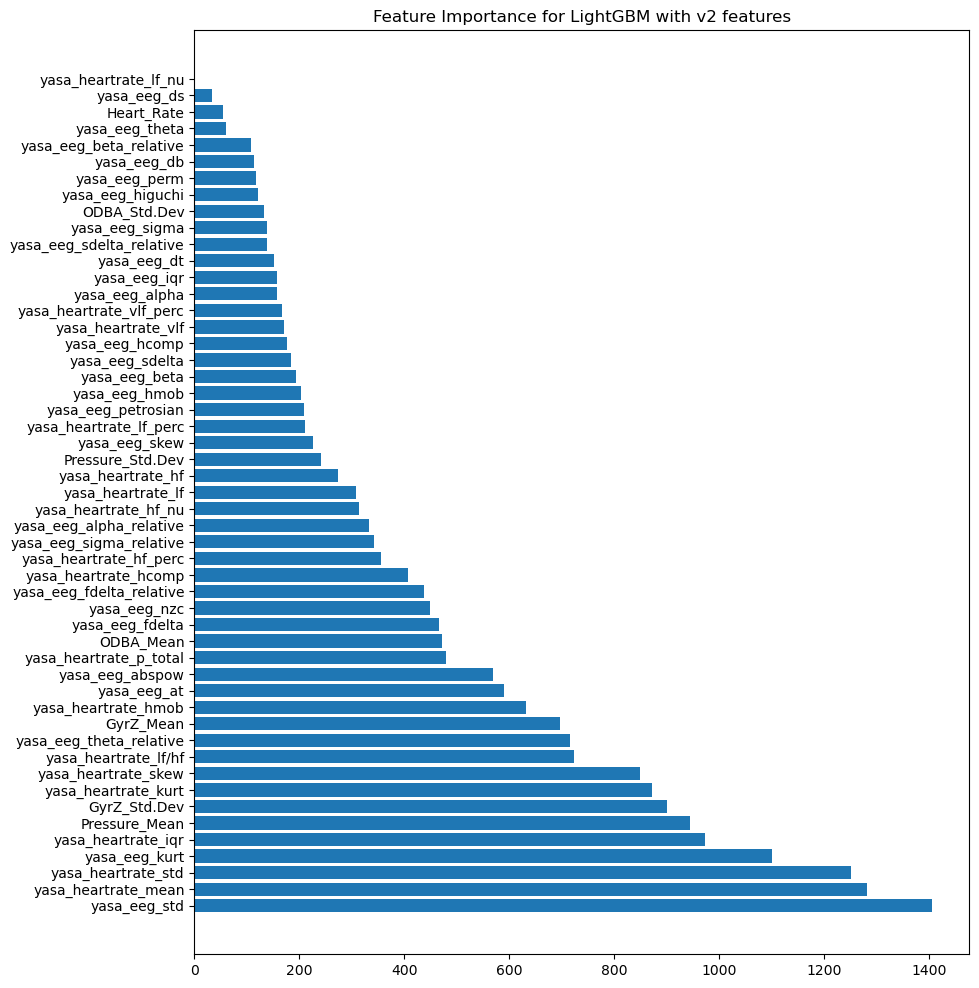

In [84]:
df_imp = pd.Series(lgbm_clf.feature_importances_, index=lgbm_clf.feature_name_, name='Importance').round()
df_imp.sort_values(ascending=False, inplace=True)
df_imp.index.name = 'Features'
plt.figure(figsize=(10, 12))
plt.barh(width=df_imp, y=df_imp.index)
plt.title('Feature Importance for LightGBM with v2 features')

<a id='nap_plotting'></a>
# Plot a few naps

In [77]:
colormap = {
    'Awake': 'lightcoral',
    'SW1': 'green',
    'SW2': 'cyan',
    'REM': 'gold',
    'Drowsy': 'mediumpurple'
}
eeg_start_sec = (features_labeled.index[0] - recording_start_datetime).total_seconds()
eeg_subset = eeg_data[int(eeg_start_sec * 500):]
def plot_nap(nap_start_dt, nap_end_dt):
    eeg_start_idx = int((nap_start_dt - features_labeled.index[0]).total_seconds() * 500)
    eeg_end_idx = int((nap_end_dt - features_labeled.index[0]).total_seconds() * 500)
    fig, ax = plt.subplots(5, 1, figsize=(9, 8))
    nap_df = features_labeled[(features_labeled.index >= nap_start_dt) &
                              (features_labeled.index <= nap_end_dt)]
    print(eeg_start_idx, eeg_end_idx)
    eeg_nap = eeg_subset[eeg_start_idx:eeg_end_idx]
    simple_sleep_codes = ['Unscorable', 'Active Waking', 'Quiet Waking', 'Drowsiness', 'SWS', 'REM']
    labels_nap = pd.concat([pd.Series(simple_sleep_codes), nap_df['Simple.Sleep.Code']], ignore_index=True)
    preds_nap = pd.concat([pd.Series(simple_sleep_codes),
                           lbgm_preds[(lbgm_preds.index >= nap_start_dt) & (lbgm_preds.index <= nap_end_dt)]],
                          ignore_index=True)
    # Labels
    sns.lineplot(labels_nap, ax=ax[0], color='black')
    ax[0].set_ylabel('True Label')
    ax[0].yaxis.tick_right()
    ax[0].set_xlim([len(simple_sleep_codes), len(labels_nap)])
    # Predictions
    sns.lineplot(preds_nap, ax=ax[1], color='purple')
    ax[1].set_ylabel('Predicted\nLabel LGBM')
    ax[1].yaxis.tick_right()
    ax[1].set_xlim([len(simple_sleep_codes), len(preds_nap)])
    # Delta Power
    sns.lineplot(nap_df['yasa_eeg_sdelta'] + nap_df['yasa_eeg_fdelta'], ax=ax[2], color='lightgreen')
    ax[2].set_ylabel('Delta Power')
    # EEG
    eeg_fig = sns.lineplot(eeg_nap, ax=ax[3], color='green')
    # plot two standard deviations from median
    eeg_median, eeg_std = np.median(eeg_nap), np.std(eeg_nap)
    print(eeg_median, eeg_std)
    ax[3].set_ylabel('EEG')
    # Heart rate
    sns.lineplot(nap_df['Heart Rate'], ax=ax[4], color='lightcoral')
    # Pressure
    #sns.lineplot(nap_df['Pressure Mean'], ax=ax[5], color='lightblue')
    for i in range(len(ax) - 1):
        ax[i].set_xticks([])
        ax[i].set_xlabel('')
    ax[3].set_ylim(-7e-5, 7e-5)
    yasa.plot_spectrogram(
        eeg_nap, 500,
        #hypno=np.array([[x] * 500 for x in features_v1['label'].apply(lambda x: hypno_map[x])]).flatten(),
        cmap='gnuplot'
    )
    plt.subplots_adjust(wspace=0, hspace=0.1)
    plt.show()

3319000 3739000
1.5550748455020534e-06 8.268405450976061e-06


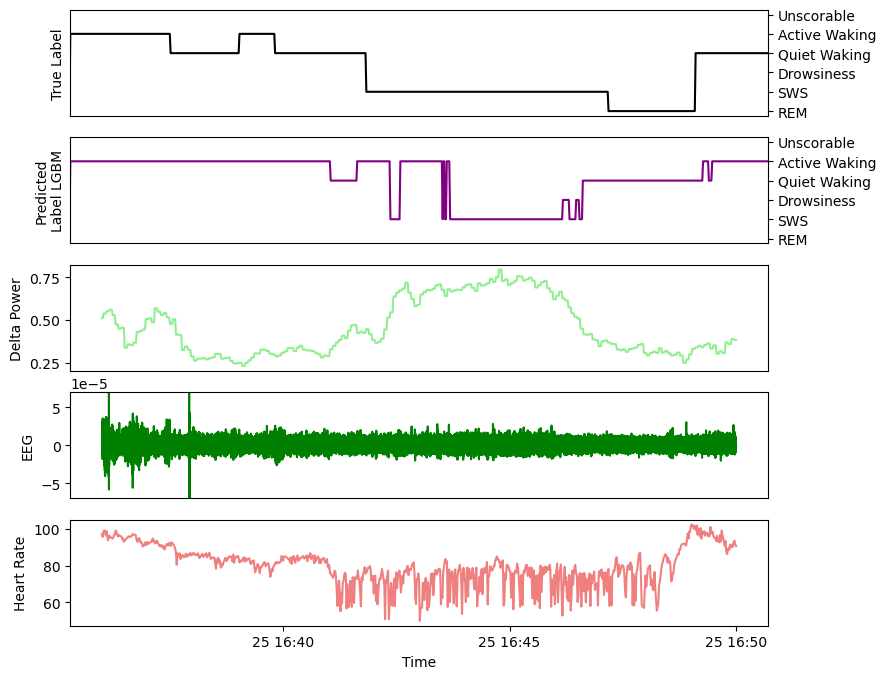

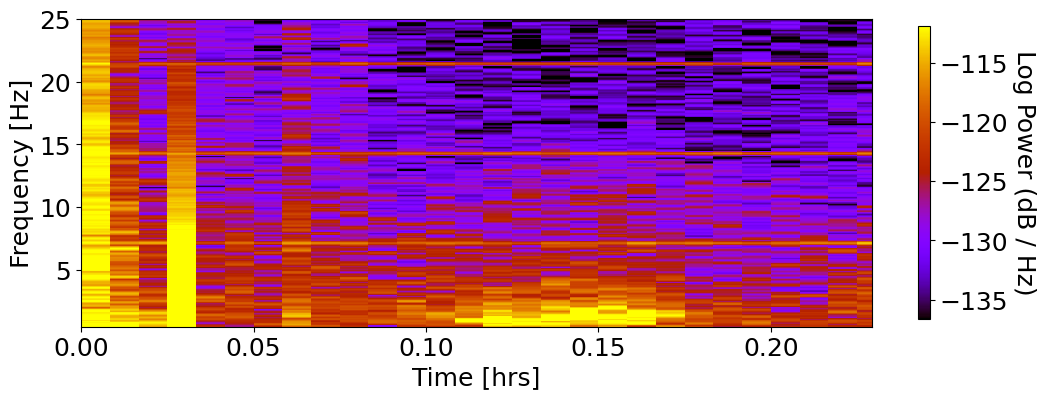

In [78]:
nap1 = (
    datetime.datetime.strptime('10/25/2019 16:36:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 16:50:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap1[0], nap1[1])


4819000 5149000
3.869005874719935e-07 4.631051375799833e-06


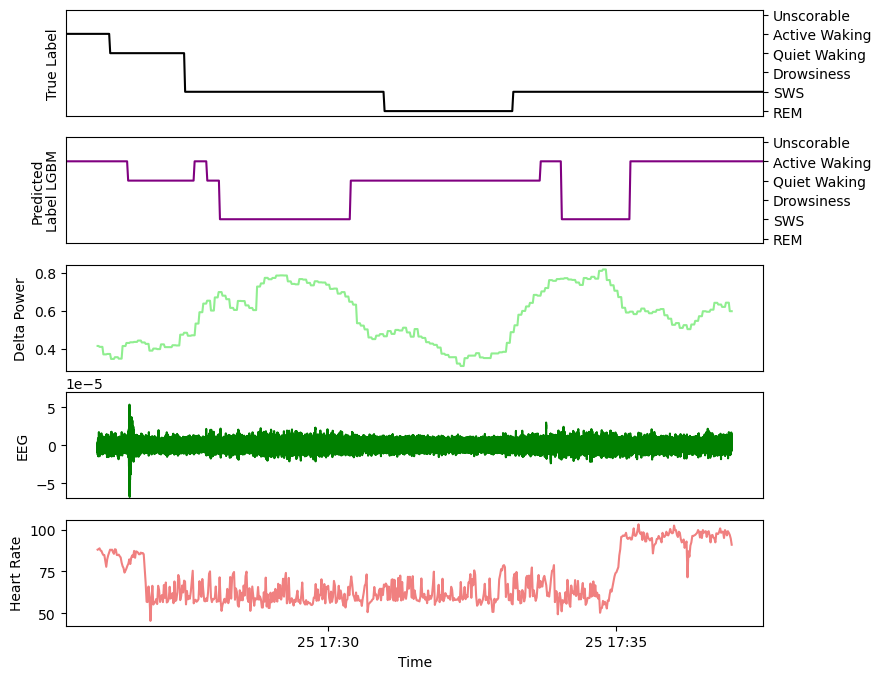

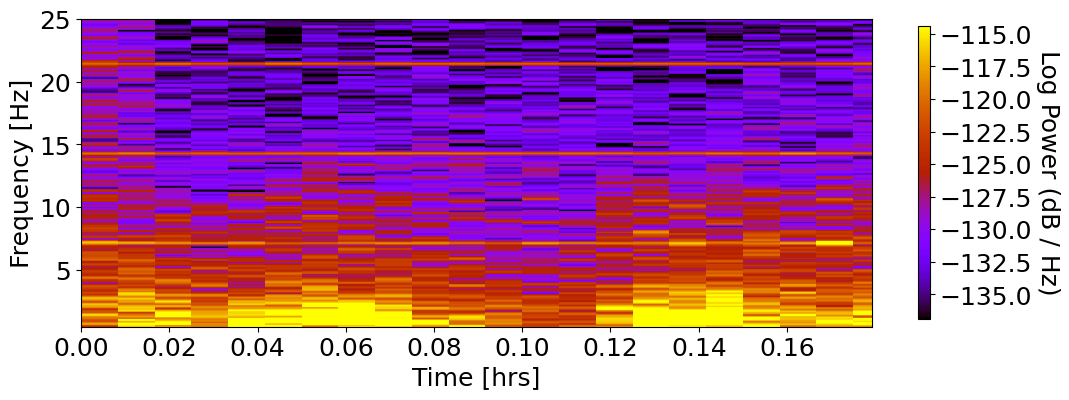

In [79]:
nap2 = (
    datetime.datetime.strptime('10/25/2019 17:26:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 17:37:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap2[0], nap2[1])


7639000 8059000
-8.036911574003191e-08 6.982866414321936e-06


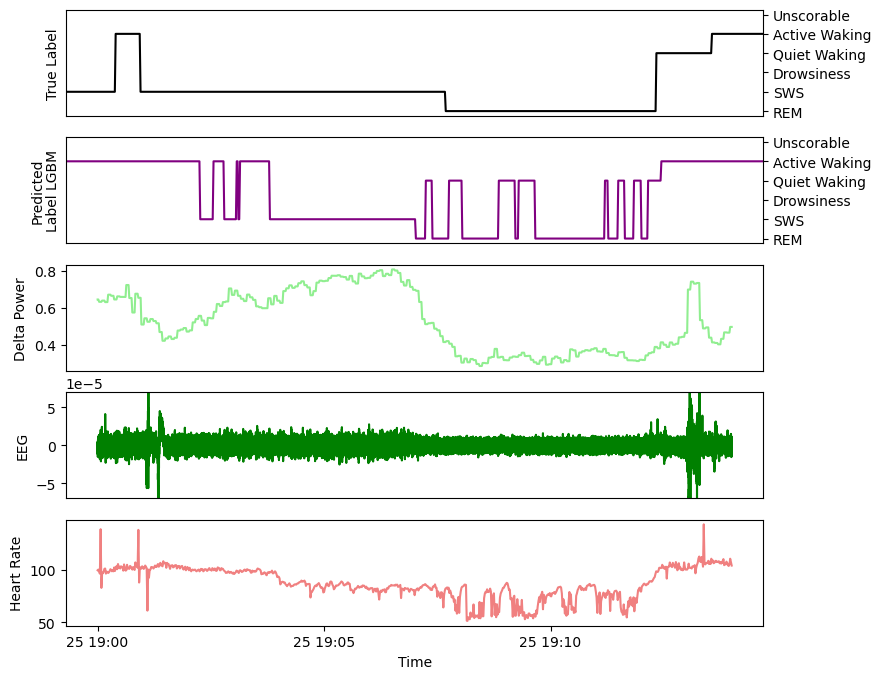

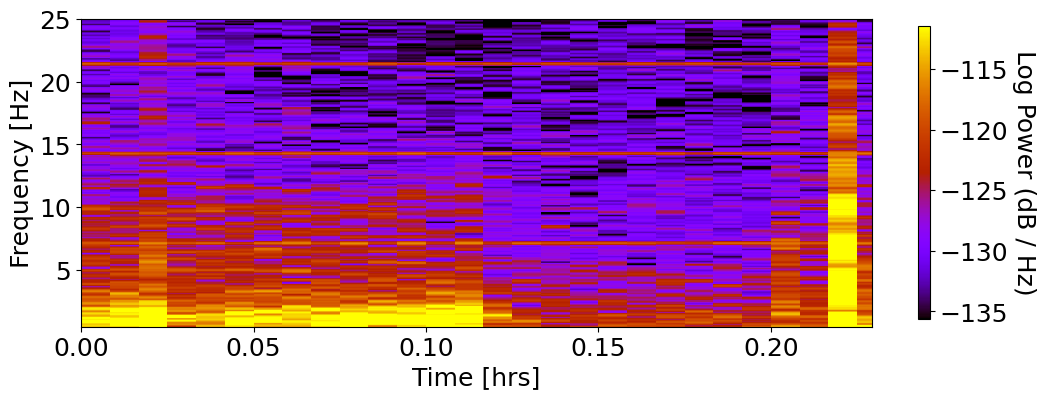

In [80]:
nap3 = (
    datetime.datetime.strptime('10/25/2019 19:00:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 19:14:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap3[0], nap3[1])


12739000 13159000
-5.476388189520556e-07 4.059263304596392e-06


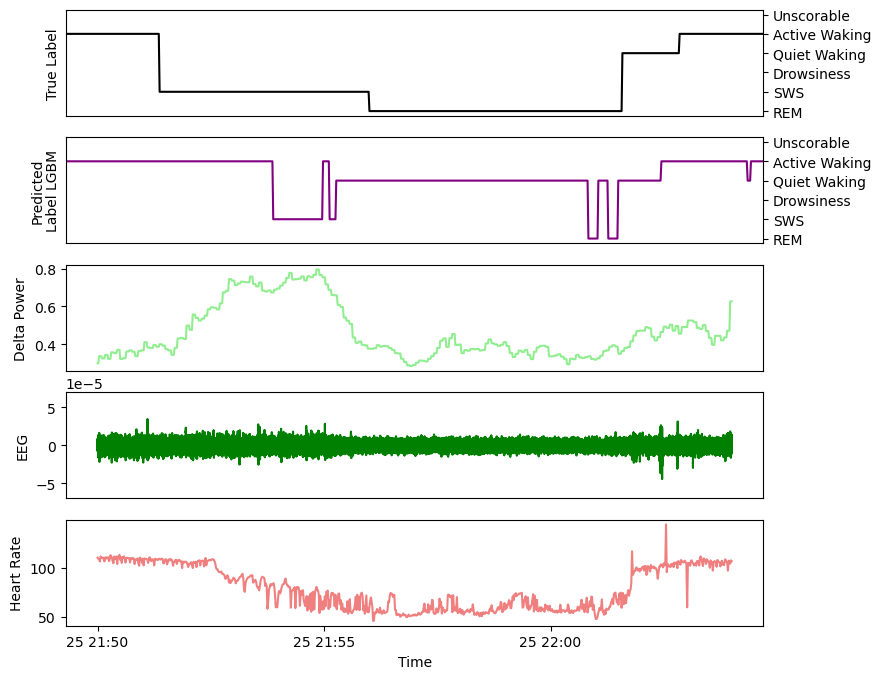

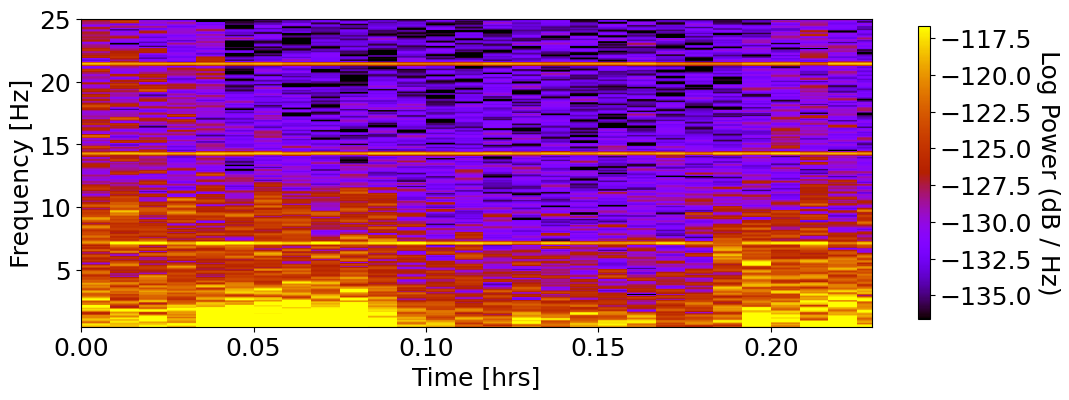

In [81]:
nap4 = (
    datetime.datetime.strptime('10/25/2019 21:50:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone),
    datetime.datetime.strptime('10/25/2019 22:04:00', '%m/%d/%Y %H:%M:%S').replace(tzinfo=None).astimezone(pst_timezone)
)
plot_nap(nap4[0], nap4[1])
